In [1]:
!pip install kaggle

In [2]:
import os
import shutil
import zipfile
import pandas as pd
import sqlite3

# Определяем пути источника и назначения
source_path = '/content/sample_data/kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')
destination_path = os.path.join(destination_dir, 'kaggle.json')

# Создаем директорию назначения, если она не существует
os.makedirs(destination_dir, exist_ok=True)

# Перемещаем файл
shutil.move(source_path, destination_path)

# Устанавливаем права доступа
os.chmod(destination_path, 0o600)

In [3]:
!kaggle datasets download -d muhammadanwaar101/healthcare-insurance-charges-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadanwaar101/healthcare-insurance-charges-dataset
License(s): unknown
  0% 0.00/16.2k [00:00<?, ?B/s]
100% 16.2k/16.2k [00:00<00:00, 61.4MB/s]


In [4]:
import zipfile

with zipfile.ZipFile('healthcare-insurance-charges-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('healthcare-insurance-charges-dataset')

In [5]:
import pandas as pd

df = pd.read_csv('/content/healthcare-insurance-charges-dataset/insurance.csv')

print(df.head())
print(df.info())
print(df.describe())

   AGE  Gender  Body_Mass_Index(BMI)  Number_of_Children Smoking_Status  \
0   19  female                27.900                   0            yes   
1   18    male                33.770                   1             no   
2   28    male                33.000                   3             no   
3   33    male                22.705                   0             no   
4   32    male                28.880                   0             no   

      Region  Insurance_Charges  
0  southwest        16884.92400  
1  southeast         1725.55230  
2  southeast         4449.46200  
3  northwest        21984.47061  
4  northwest         3866.85520  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE                   1407 non-null   int64  
 1   Gender                1407 non-null   object 
 2   Body_Mass_Index(BMI)  1407 non

Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
MAE: 2429.063364742908
MSE: 17834030.71970057
R²: 0.9003409697727066


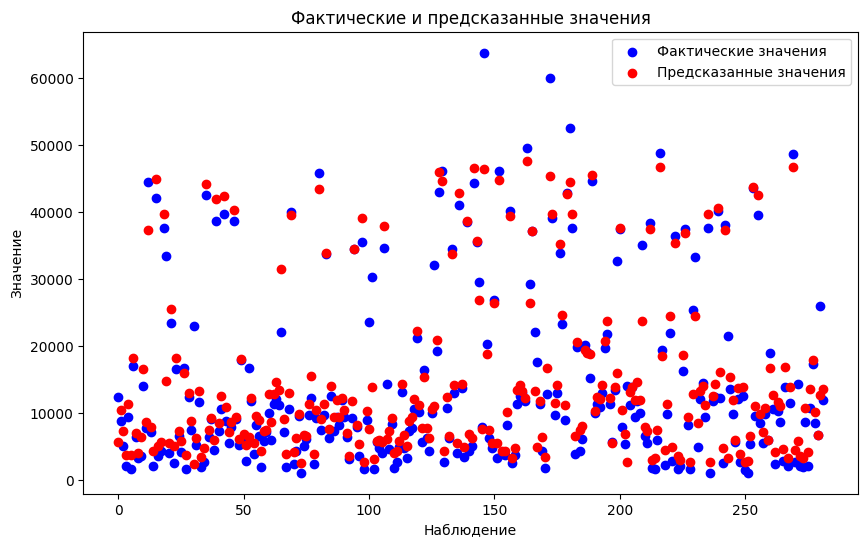

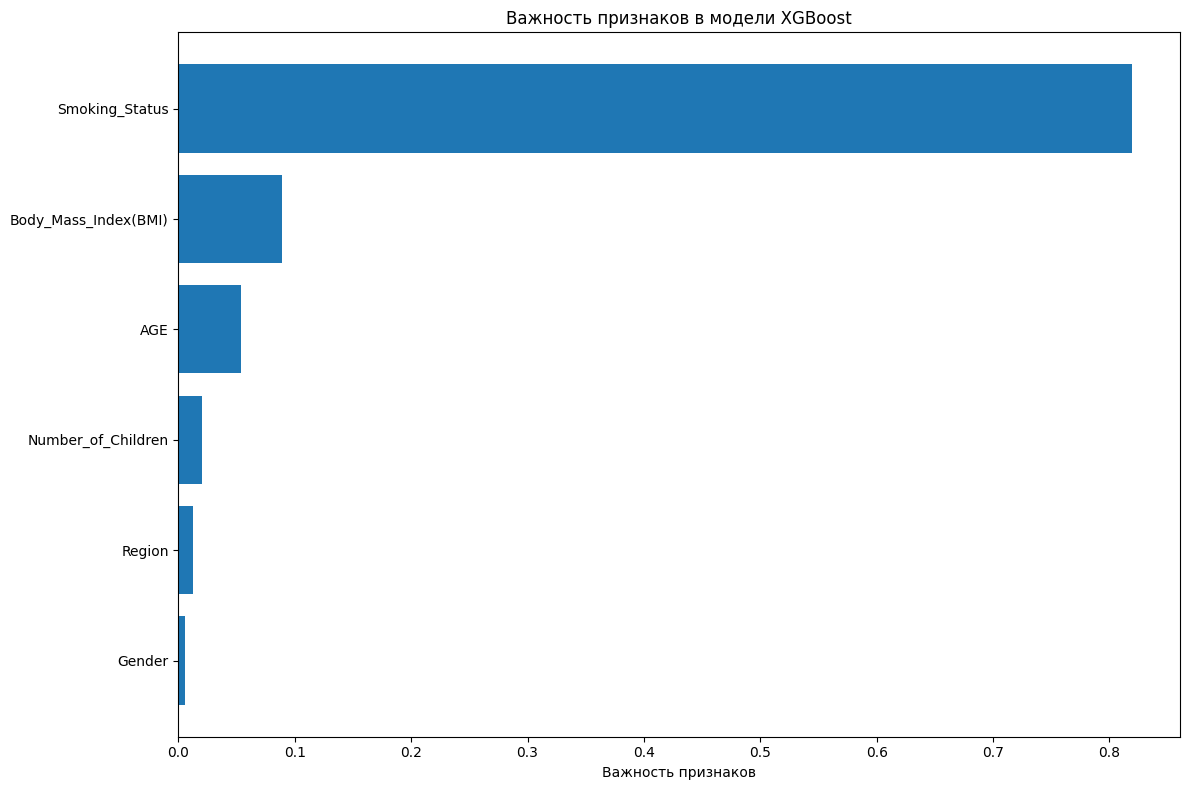

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

target = df['Insurance_Charges']
features = df.drop('Insurance_Charges', axis=1)

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Определение модели
model = XGBRegressor()

# Определение параметров для подбора
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Использование лучших параметров для обучения модели
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Визуализация предсказанных и фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Фактические значения')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Предсказанные значения')
plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Фактические и предсказанные значения')
plt.legend()
plt.show()


plt.figure(figsize=(12, 8))
feature_importance = best_model.feature_importances_
feature_names = features.columns

# Сортируем по важности
indices = np.argsort(feature_importance)[::-1]

plt.barh(range(len(feature_importance)), feature_importance[indices])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices])
plt.xlabel('Важность признаков')
plt.title('Важность признаков в модели XGBoost')
plt.gca().invert_yaxis()  # Самый важный признак сверху
plt.tight_layout()
plt.show()

In [9]:
print(f"Среднее значение целевой переменной: {y_train.mean()}")
print(f"Std целевой переменной: {y_train.std()}")
print(f"MAE относительно среднего: {(2429.06/y_train.mean())*100:.1f}%")

Среднее значение целевой переменной: 12884.507442443557
Std целевой переменной: 11738.971752127783
MAE относительно среднего: 18.9%


Метрики качества модели Random Forest Regressor:
MAE: 2269.2286
MSE: 17406067.2756
RMSE: 4172.0579
R²: 0.9027


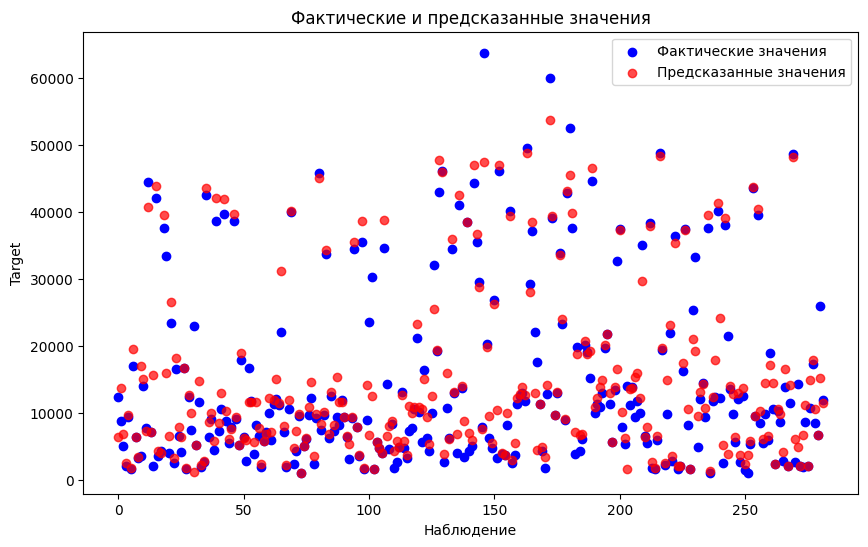

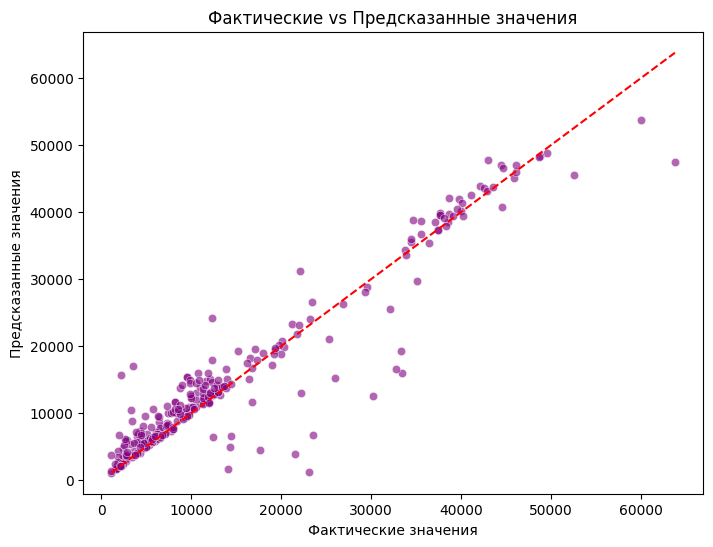

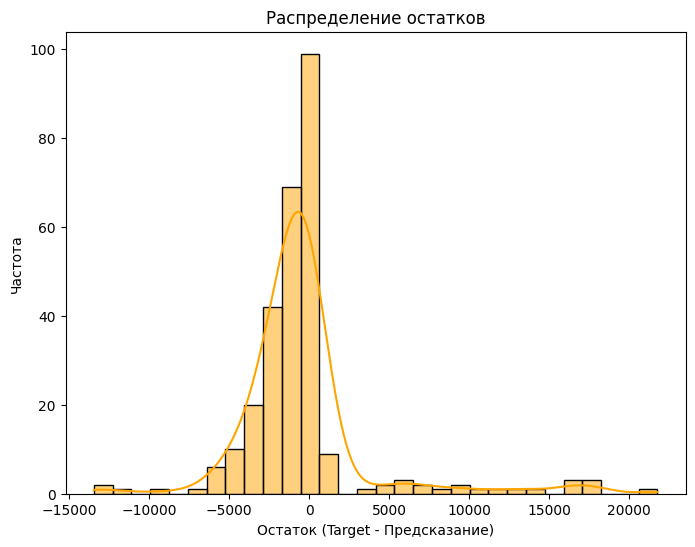

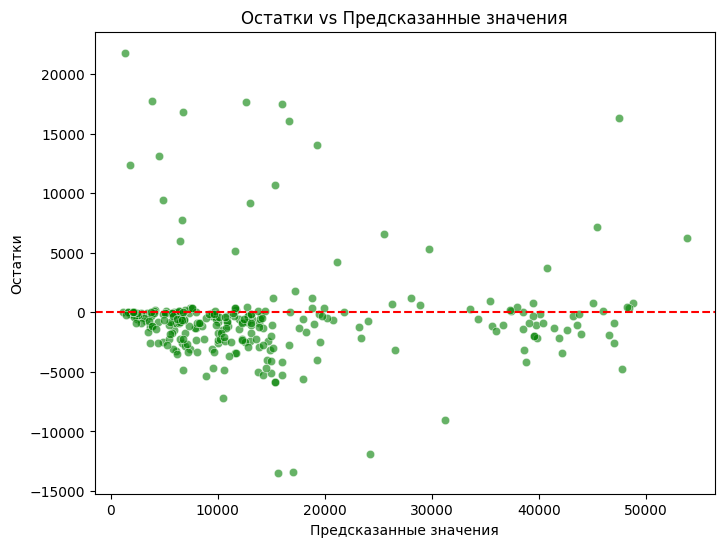

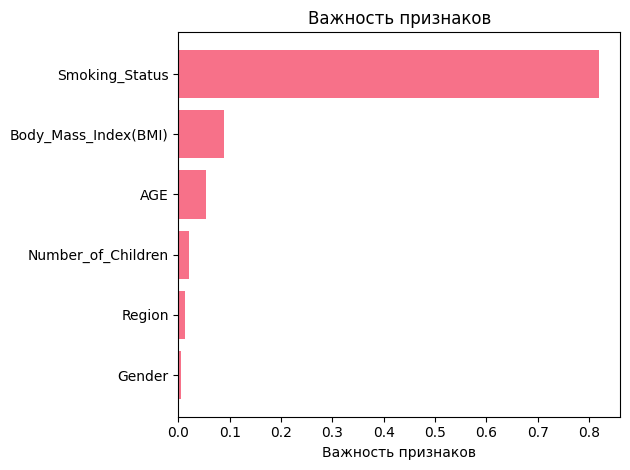

In [46]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Создание и обучение модели Random Forest Regressor
rfr = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rfr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f'Метрики качества модели Random Forest Regressor:')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


# Визуализация предсказанных и фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Фактические значения')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Предсказанные значения', alpha=0.7)
plt.xlabel('Наблюдение')
plt.ylabel('Target')
plt.title('Фактические и предсказанные значения')
plt.legend()
plt.show()

# Диаграмма предсказанных vs фактических значений
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения')
plt.show()

# График остатков
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title('Распределение остатков')
plt.xlabel('Остаток (Target - Предсказание)')
plt.ylabel('Частота')
plt.show()

# Остатки vs Предсказанные значения
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')
plt.show()

# Сортируем по важности
indices = np.argsort(feature_importance)[::-1]

plt.barh(range(len(feature_importance)), feature_importance[indices])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices])
plt.xlabel('Важность признаков')
plt.title('Важность признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean Squared Error (MSE): 42235530.32892502
Mean Absolute Error (MAE): 3363.8630159071986
R-squared (R2): 0.7639820150659259


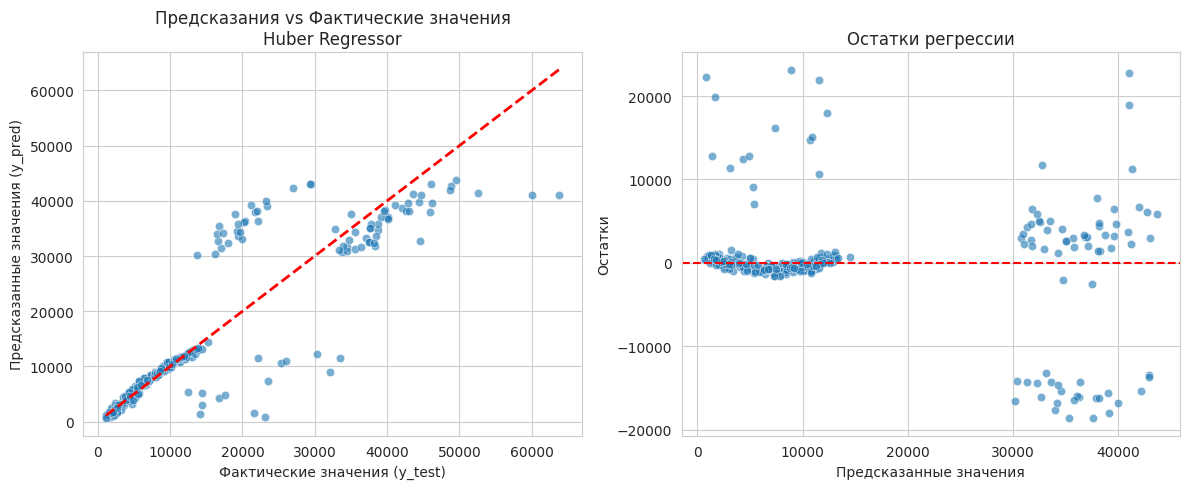

In [31]:
from sklearn.linear_model import HuberRegressor

model = HuberRegressor(epsilon=1.35)  # Задаем параметр epsilon, который контролирует устойчивость к выбросам
model.fit(X_train, y_train)

# Сделаем предсказания
y_pred = model.predict(X_test)

# Вычислим метрики
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выведем метрики
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Настройка стиля Seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения (y_test)')
plt.ylabel('Предсказанные значения (y_pred)')
plt.title('Предсказания vs Фактические значения\nHuber Regressor')
plt.grid(True)

# График остатков
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки регрессии')
plt.grid(True)
plt.tight_layout()
plt.show()

Фиктивный регрессор - Средняя абсолютная ошибка (MAE): 9835.17
Фиктивный регрессор - Среднеквадратичная ошибка (MSE): 181776408.71
Фиктивный регрессор - Коэффициент детерминации (R²): -0.02


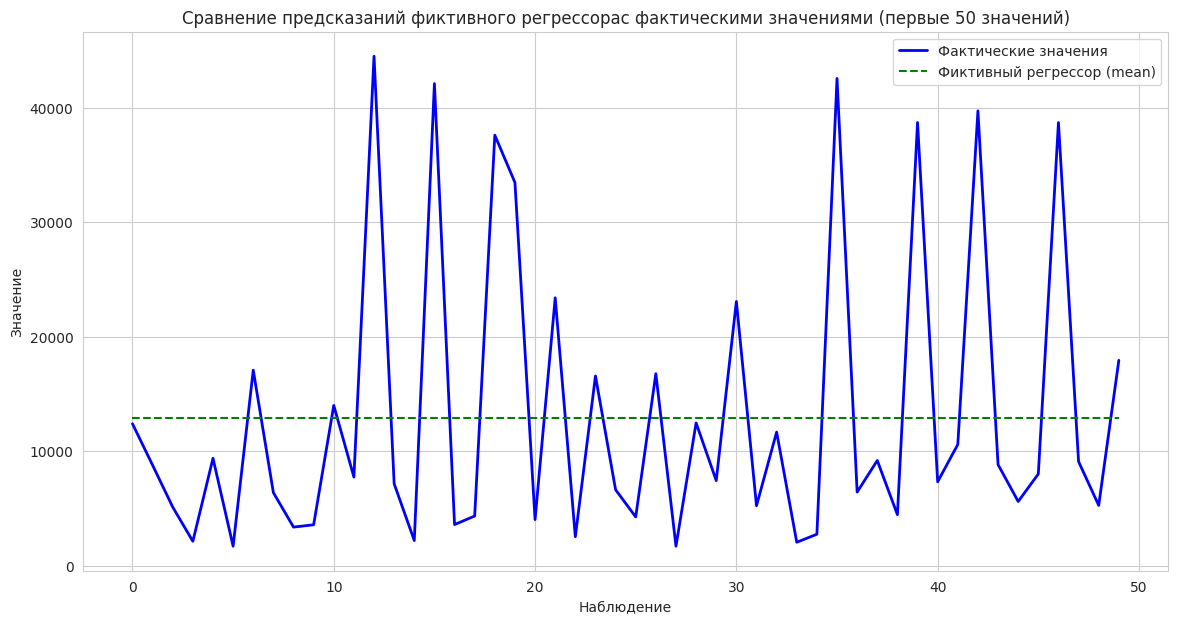

In [32]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy='mean')

# Обучаем фиктивный регрессор
dummy_regressor.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе
y_pred_dummy = dummy_regressor.predict(X_test)

# Вычисление метрик для фиктивного регрессора
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print(f"Фиктивный регрессор - Средняя абсолютная ошибка (MAE): {mae_dummy:.2f}")
print(f"Фиктивный регрессор - Среднеквадратичная ошибка (MSE): {mse_dummy:.2f}")
print(f"Фиктивный регрессор - Коэффициент детерминации (R²): {r2_dummy:.2f}")


# Визуализируем предсказания фиктивного регрессора с фактическими значениями (первые 50 значений)
plt.figure(figsize=(14, 7))

plt.plot(range(50), y_test.iloc[:50], label='Фактические значения', color='blue', linewidth=2)
plt.plot(range(50), y_pred_dummy[:50], label='Фиктивный регрессор (mean)', color='green', linestyle='--')

plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Сравнение предсказаний фиктивного регрессорас фактическими значениями (первые 50 значений)')
plt.legend()
plt.show()

MAE: 2534.3038579572058
MSE: 18916045.606745444
R²: 0.8942945209340115


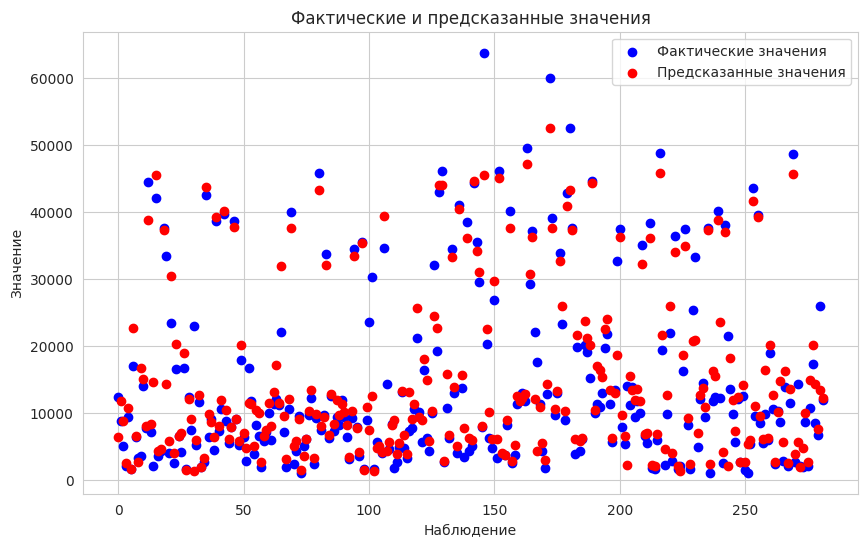

In [33]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# Определение базовых регрессоров
regressor1 = LinearRegression()
regressor2 = DecisionTreeRegressor(random_state=42)
regressor3 = RandomForestRegressor(n_estimators=100, random_state=42)
regressor4 = XGBRegressor()

# Определение ансамбля регрессоров (VotingRegressor)
voting_regressor = VotingRegressor(estimators=[
    ('lr', regressor1),
    ('dt', regressor2),
    ('rf', regressor3),
    ('xgb', regressor4)
])

# Обучение ансамбля регрессоров
voting_regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = voting_regressor.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

# Визуализация предсказанных и фактических значений
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Фактические значения')
plt.scatter(range(len(y_test)), y_pred, color='red', label='Предсказанные значения')
plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Фактические и предсказанные значения')
plt.legend()
plt.show()

ElasticNet - Средняя абсолютная ошибка (MAE): 5225.86
ElasticNet - Среднеквадратичная ошибка (MSE): 49671185.47
ElasticNet - Коэффициент детерминации (R²): 0.72


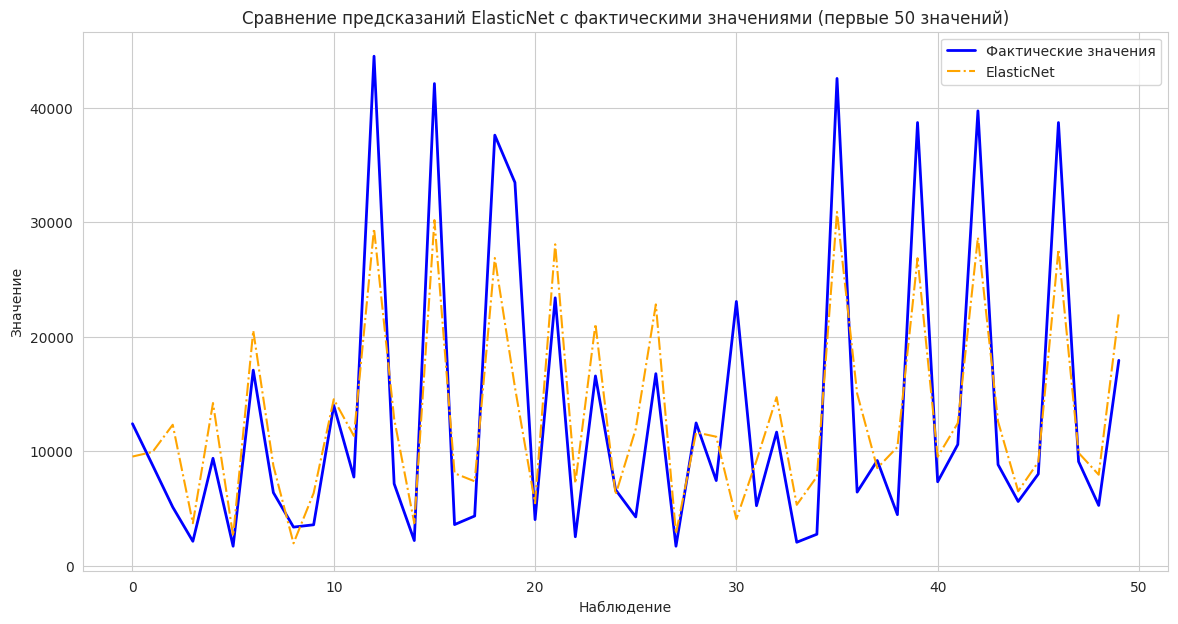

In [34]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

# Обучаем модель ElasticNet
elastic_net.fit(X_train, y_train)

# Делаем прогнозы на тестовом наборе
y_pred_en = elastic_net.predict(X_test)

# Вычисление метрик для ElasticNet
mae_en = mean_absolute_error(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
r2_en = r2_score(y_test, y_pred_en)

print(f"ElasticNet - Средняя абсолютная ошибка (MAE): {mae_en:.2f}")
print(f"ElasticNet - Среднеквадратичная ошибка (MSE): {mse_en:.2f}")
print(f"ElasticNet - Коэффициент детерминации (R²): {r2_en:.2f}")

# Визуализируем предсказания ElasticNet и фактические значения (первые 50 значений)
plt.figure(figsize=(14, 7))
plt.plot(range(50), y_test.iloc[:50], label='Фактические значения', color='blue', linewidth=2)
plt.plot(range(50), y_pred_en[:50], label='ElasticNet', color='orange', linestyle='-.')

plt.xlabel('Наблюдение')
plt.ylabel('Значение')
plt.title('Сравнение предсказаний ElasticNet с фактическими значениями (первые 50 значений)')
plt.legend()
plt.show()

In [44]:
print("Модель               R²      MAE    RMSE")
print("-" * 40)
for _, row in results_df.iterrows():
    print(f"{row['Model']:20} {row['R2']:.4f} {row['MAE']:6.1f} {row['RMSE']:6.1f}")
print(f"\nЛучшая: {results_df.iloc[0]['Model']}")

Модель               R²      MAE    RMSE
----------------------------------------
Random Forest        0.9027 2269.2 4172.1
Voting Regressor     0.8807 3023.5 4620.5
XGBoost              0.8741 2771.8 4747.3
Huber                0.7640 3363.9 6498.9
Elastic Net          0.7224 5225.9 7047.8
Dummy Regressor      -0.0158 9835.2 13482.4

Лучшая: Random Forest
